In [8]:
from itertools import count
import numpy as np
import pandas as pd
import psycopg2
import dotenv
import os
from matplotlib import animation
from matplotlib import pyplot as plt
from mplsoccer import Pitch
from scipy.interpolate import interp1d

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)


matches_1 = """
SELECT  
    me.*, 
    et.name AS event_name,  
    et.description AS event_description  
FROM public.matchevents me
INNER JOIN public.eventtypes et USING(eventtype_id)
INNER JOIN public.matches m USING(match_id)
WHERE m.match_id = '5pcyhm34h5c948yji4oryevpw'
"""

df_matches = pd.read_sql_query(matches_1,conn)


# Convert timedelta-like format to seconds
df_matches["timestamp"] = df_matches["timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)
df_matches["end_timestamp"] = df_matches["end_timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)

# Fill NaN with the previous event's timestamp (forward fill)
# df_matches['timestamp'] = df_matches['timestamp'].fillna(method='ffill')
# df_matches['end_timestamp'] = df_matches['end_timestamp'].fillna(method='ffill')
from sklearn.impute import KNNImputer

# Initialize the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputer to the timestamp and end_timestamp columns
df_matches[['timestamp', 'end_timestamp']] = imputer.fit_transform(df_matches[['timestamp', 'end_timestamp']])


# Check the result
print(df_matches[["timestamp", "end_timestamp"]].head())


df_matches.head()

X = df_matches[["timestamp", "end_timestamp"]].values

   timestamp  end_timestamp
0      0.087         1.6270
1      1.627         4.1780
2      4.178         6.6718
3      6.575         9.8552
4      6.576         9.8552


   timestamp  end_timestamp  cluster
0      0.087         1.6270        2
1      1.627         4.1780        2
2      4.178         6.6718        2
3      6.575         9.8552        2
4      6.576         9.8552        2


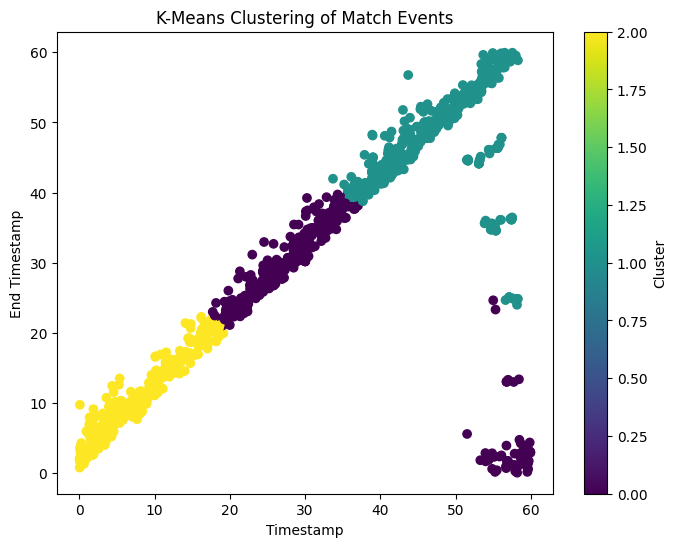

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
df_matches['cluster'] = kmeans.fit_predict(X)

# Add the cluster labels to the DataFrame
print(df_matches[['timestamp', 'end_timestamp', 'cluster']].head())

# Optional: Plot the clusters (2D plot with timestamps and end_timestamps)
plt.figure(figsize=(8, 6))
plt.scatter(df_matches['timestamp'], df_matches['end_timestamp'], c=df_matches['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Match Events')
plt.xlabel('Timestamp')
plt.ylabel('End Timestamp')
plt.colorbar(label='Cluster')
plt.show()